In [1]:
!pip install contextily

# Import Library

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import folium
from folium.plugins import HeatMap

import geopandas as gpd
import contextily as ctx


# Membaca dataset

* menghubungkan gdrive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* membaca dataset

In [4]:
df_iris = pd.read_csv('/content/drive/MyDrive/praktikum_ml/praktikum11/data/Iris.csv')
df_airport = pd.read_csv('/content/drive/MyDrive/praktikum_ml/praktikum11/data/airport.csv')


df_iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
df_airport.head()

,id,name,city,country,iata,icao,latitude,longitude,altitude,timezone_offset,dst,timezone,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,NaN
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,NaN
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,NaN
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,NaN
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,NaN


# Membersihkan dataset airport

In [6]:
df_airport.isnull().sum()

,0
id,0
name,0
city,49
country,0
iata,0
icao,0
latitude,0
longitude,0
altitude,0
timezone_offset,0


In [7]:
# Drop the 'source' column if it exists, as it contains all NaN values and is not useful for analysis
df = df_airport.drop(columns=['source'], errors='ignore')

# Drop rows where 'city' is NaN
df = df_airport.dropna(subset=['city'])

In [8]:
df_airport = df_airport.dropna(subset=['latitude','longitude'])
df_airport = df_airport[df_airport['latitude'] != 0]
df_airport = df_airport[df_airport['longitude'] != 0]

# Visualisasi Scatter plot Bandara

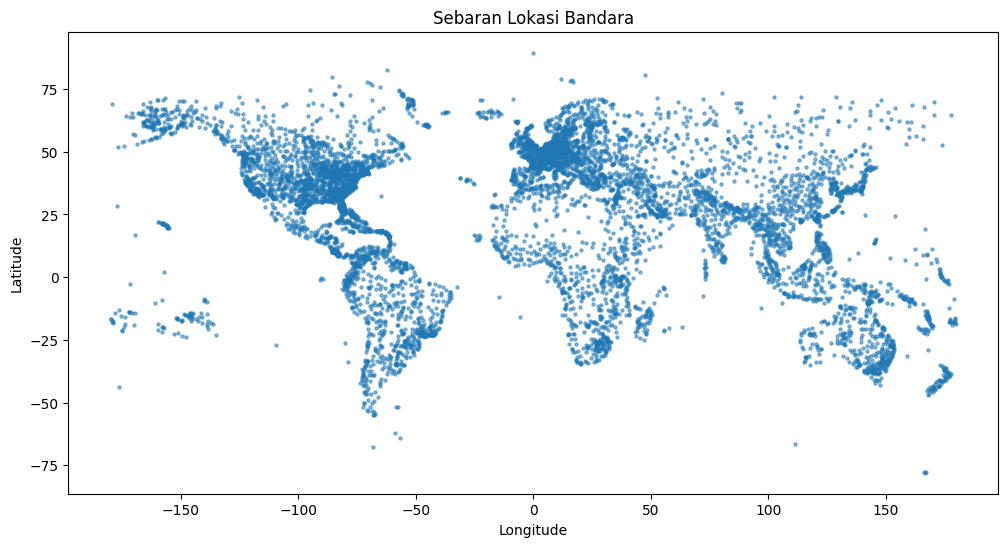

In [9]:
plt.figure(figsize=(12,6))
plt.scatter(df_airport['longitude'], df_airport['latitude'], s=5, alpha=0.5)
plt.title("Sebaran Lokasi Bandara")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

* visualisasi aiport di berbagai benua

In [29]:
m = folium.Map(location=[0,0], zoom_start=2)
heat_data = df_airport[['latitude','longitude']].values.tolist()
HeatMap(heat_data, radius=8).add_to(m)
m

In [11]:
df.columns

Index(['id', 'name', 'city', 'country', 'iata', 'icao', 'latitude',
       'longitude', 'altitude', 'timezone_offset', 'dst', 'timezone', 'type',
       'source'],
      dtype='object')

* visualisasi peta airport di negara US

In [12]:
# Filter bandara yang hanya ada di United States
df_us = df[df['country'] == 'United States']

# Membuat peta terpusat di wilayah US
peta_us = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Data untuk heatmap: [lat, long]
data_heatmap_us = df_us[['latitude', 'longitude']].values.tolist()

# Tambahkan layer heatmap khusus bandara US
HeatMap(data_heatmap_us, radius=6, blur=8, max_zoom=6).add_to(peta_us)

peta_us

# Visualisasi Basemap

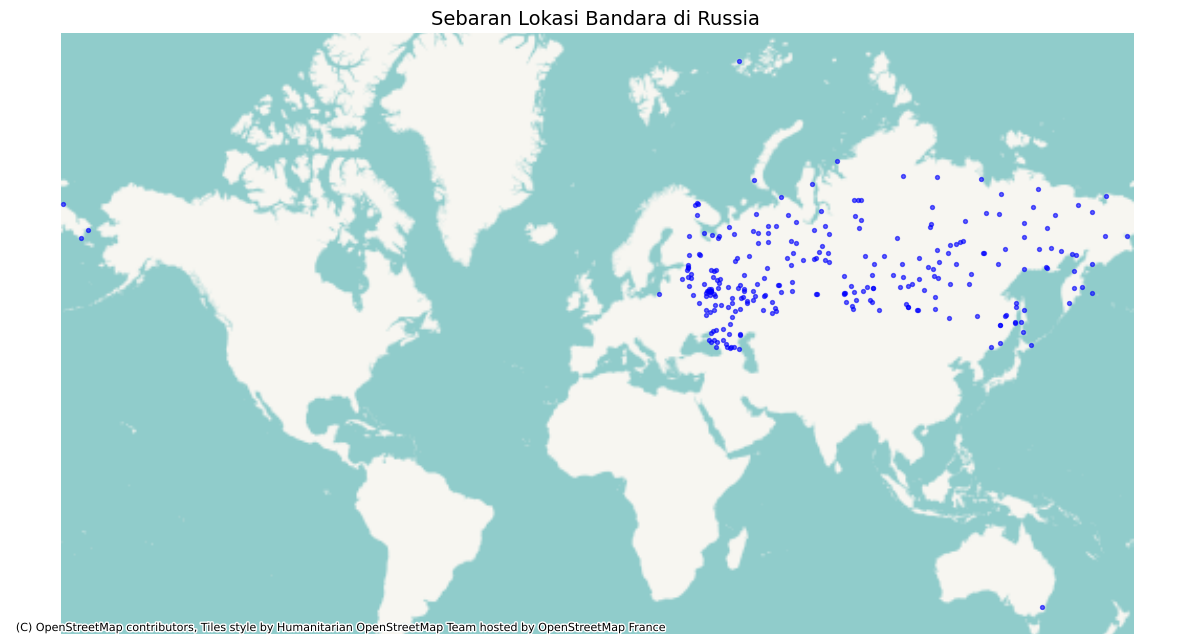

In [18]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Filter bandara untuk negara Russia
df_rus = df_airport[df_airport['country'] == 'Russia']

# Konversi ke GeoDataFrame
gdf_rus = gpd.GeoDataFrame(
    df_rus,
    geometry=gpd.points_from_xy(df_rus['longitude'], df_rus['latitude']),
    crs="EPSG:4326"
)

# Konversi ke Web Mercator (wajib agar bisa memakai basemap contextily)
gdf_rus = gdf_rus.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(12,8))

# Plot titik bandara
gdf_rus.plot(ax=ax, markersize=8, color='blue', alpha=0.6)

# Tambahkan basemap OSM
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.HOT)

# Judul peta
ax.set_title("Sebaran Lokasi Bandara di Russia", fontsize=14)

# Hilangkan sumbu koordinat
ax.set_axis_off()

plt.tight_layout()
plt.show()


# **DBSCAN IRIS**

In [19]:
X = df_iris.iloc[:, :-1]   # semua fitur kecuali species

* normalisasi data Iris

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/tmp/ipython-input-1696285724.py:28: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipython-input-1696285724.py:35: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



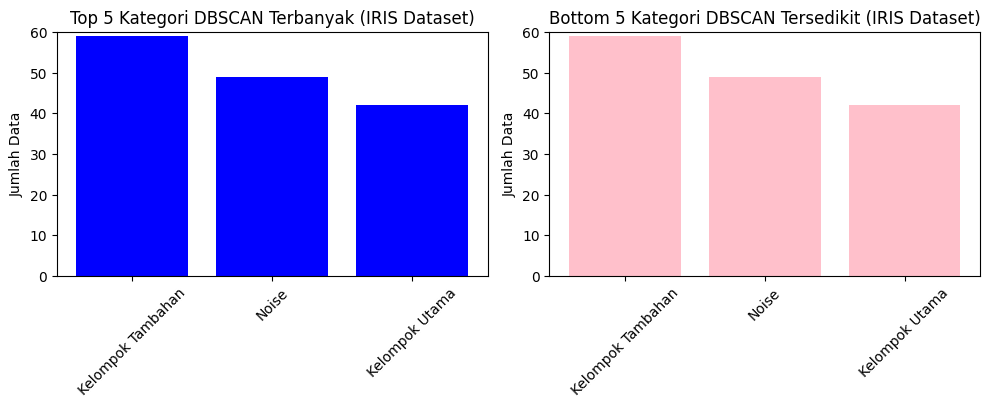

In [28]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 2. Persiapan Data IRIS untuk Top & Bottom

jumlah_cluster = df_iris['Klasifikasi_DBSCAN'].value_counts()

top_5 = jumlah_cluster.head(5)
bottom_5 = jumlah_cluster.tail(5)


# 3. Layout Figure Menggunakan GridSpec

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 2])


# ROW 2: Chart Top vs Bottom

# Chart TOP
ax_top = plt.subplot(gs[1, 0])
ax_top.bar(top_5.index, top_5.values, color="blue")
ax_top.set_title("Top 5 Kategori DBSCAN Terbanyak (IRIS Dataset)")
ax_top.set_ylabel("Jumlah Data")
ax_top.set_xticklabels(top_5.index, rotation=45)

# Chart BOTTOM
ax_bottom = plt.subplot(gs[1, 1])
ax_bottom.bar(bottom_5.index, bottom_5.values, color="pink")
ax_bottom.set_title("Bottom 5 Kategori DBSCAN Tersedikit (IRIS Dataset)")
ax_bottom.set_ylabel("Jumlah Data")
ax_bottom.set_xticklabels(bottom_5.index, rotation=45)

# 4. Sinkronisasi Skala Chart

max_val = max(top_5.max(), bottom_5.max()) + 1
ax_top.set_ylim(0, max_val)
ax_bottom.set_ylim(0, max_val)

plt.tight_layout()
plt.show()

* menentukan EPS dengan K-Distance Graph

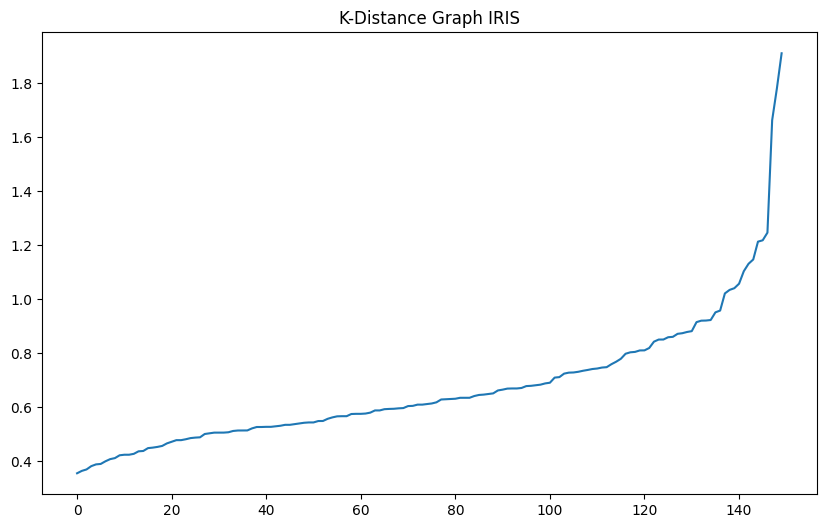

In [21]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:,4])
plt.figure(figsize=(10,6))
plt.plot(distances)
plt.title("K-Distance Graph IRIS")
plt.show()

* DBSCAN Clustering

In [22]:
db = DBSCAN(eps=0.6, min_samples=5)
labels = db.fit_predict(X_scaled)

df_iris['cluster'] = labels
df_iris['cluster'].value_counts()

,count
cluster,
-1,49
0,42
1,34
3,15
2,10


* evaluasi clustering

In [23]:
sil = silhouette_score(X_scaled, labels)
print("Silhouette Score:", sil)

Silhouette Score: 0.15181057619953842


* visualisasi PCA (2D)

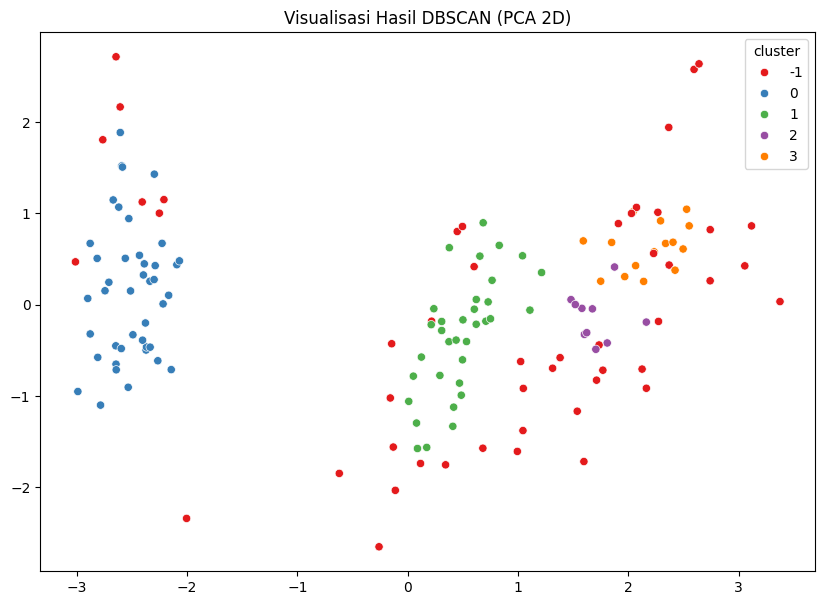

In [24]:
pca = PCA(n_components=2)
pca_vals = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,7))
sns.scatterplot(x=pca_vals[:,0], y=pca_vals[:,1], hue=df_iris['cluster'], palette='Set1')
plt.title("Visualisasi Hasil DBSCAN (PCA 2D)")
plt.show()

* pengelompokan kualitatif cluster

In [25]:
# Fungsi untuk mengubah cluster numerik menjadi deskriptif
def klasifikasi_db(x):
    if x == 0:
        return "Kelompok Utama"
    elif x == -1:
        return "Noise"
    else:
        return "Kelompok Tambahan"

# Membuat kolom baru sesuai hasil DBSCAN
df_iris['Klasifikasi_DBSCAN'] = df_iris['cluster'].apply(klasifikasi_db)

# Menampilkan jumlah tiap kategori
print(df_iris['Klasifikasi_DBSCAN'].value_counts())

Klasifikasi_DBSCAN
Kelompok Tambahan    59
Noise                49
Kelompok Utama       42
Name: count, dtype: int64


* analisis lanjutan per cluster (cluster summary)

In [26]:
# Menghapus kolom non-numerik kecuali label cluster
df_summary = df_iris.drop(columns=['Species'])

# Melakukan ringkasan rata-rata per kelompok DBSCAN
cluster_summary_iris = (
    df_summary
    .groupby('Klasifikasi_DBSCAN')
    .mean()
    .round(3)
)

cluster_summary_iris

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,cluster
Klasifikasi_DBSCAN,,,,,,
Kelompok Tambahan,98.780,6.251,2.917,4.766,1.622,1.678
Kelompok Utama,23.476,4.983,3.357,1.464,0.243,0.000
Noise,92.061,6.090,2.959,4.512,1.508,-1.000


* visualisasi interaktif persebaran cluster (plotly)

In [27]:
import plotly.express as px
import pandas as pd

# Membuat DataFrame PCA 2D
df_pca_iris = pd.DataFrame(pca_vals, columns=["PCA 1", "PCA 2"])

# Menambahkan kolom klasifikasi deskriptif
df_pca_iris["Klasifikasi_DBSCAN"] = df_iris["Klasifikasi_DBSCAN"].values

# Tambahkan info tambahan untuk hover
df_pca_iris["Species"] = df_iris["Species"].values
df_pca_iris["Cluster"] = df_iris["cluster"].values

# Plotly Interaktif
fig = px.scatter(
    df_pca_iris,
    x="PCA 1",
    y="PCA 2",
    color="Klasifikasi_DBSCAN",
    hover_name="Species",
    hover_data={
        "Cluster": True,
        "PCA 1": False,
        "PCA 2": False
    },
    title="Persebaran Data IRIS Berdasarkan Klasifikasi DBSCAN (Visualisasi Interaktif)",
    width=1200,
    height=700
)

fig.show()